In [1]:
import numpy as np
import tensorflow as tf
import tenfem
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from tenfem.layers import AssembleStiffnessMatrix, AssembleLoadVector

## The `TriangleMesh` object

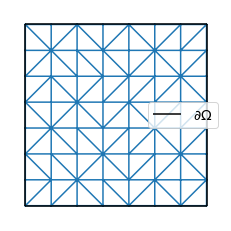

In [2]:
mesh = tenfem.mesh.examples.square(8, 8)

fig, ax = plt.subplots()
ax.triplot(mesh._triang)

ax.add_collection(
    LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
ax.legend(fontsize=14)
ax.set_aspect('equal'); ax.axis('off')
for method in [ax.set_xlim, ax.set_ylim]:
    method((-0.1, 1.1))

plt.show()

## The `reference_element` 

The mesh above is a `tenfem.mesh.TriangleMesh` object, one of the most beautiful
aspects of the Finite Element Method is that the problem over the domain $\Omega$
is divided first into "physical elements" -- our triangles in the mesh above, and
then in terms of each of these physical elements to a single canonical 
`reference_element`, and also specify a bijection between the physical elements
and the canonical element.

One of the most important ways this manifests is that whenever we are doing integration
over a physical element, we parameterise in terms of coordinates of the reference element,
and in practice specify integrations by quadratures over the reference element. Once
we have specified a quadrature order, all of the callable components of our model will be
queried for values at these quadrature nodes, so lets inspect them.

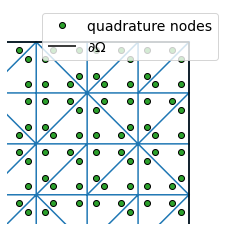

In [3]:
lin_tri_element = tenfem.reference_elements.TriangleElement(degree=1)
quadrature_nodes = lin_tri_element.get_quadrature_nodes(mesh)

fig, ax = plt.subplots()
ax.triplot(mesh._triang)
ax.set_aspect('equal'); ax.axis('off')

ax.plot(*tf.reshape(quadrature_nodes, [-1, 2]).numpy().T, 
        'o', markeredgecolor='k', label='quadrature nodes')
ax.add_collection(
    LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
ax.legend(fontsize=14)

for method in [ax.set_xlim, ax.set_ylim]:
    method((0.49, 1.1))
plt.show()

## `AssembleStiffnessMatrix`

In [4]:
mesh = tenfem.mesh.examples.square(32, 32)  # lets make a higher res mesh to see the solution

mesh_tensor_repr = mesh.get_tensor_repr()
diffusion_coefficient = lambda x: tf.ones_like(x)[..., 0]
source = lambda x: -6. * tf.ones_like(x)[..., 0]

ud = lambda x: (1 + x[...,0]**2 + 2. * x[..., 1]**2)[..., tf.newaxis]


stiffness_matrix = AssembleStiffnessMatrix(diffusion_coefficient,
                                           reference_element=lin_tri_element)(mesh_tensor_repr)
load_vector = AssembleLoadVector(source,
                                 reference_element=lin_tri_element)(mesh_tensor_repr)
node_types = mesh_tensor_repr[-1]
boundary_values = ud(tf.gather_nd(mesh.nodes, tf.where(node_types == 1)))

In [6]:
solution = tenfem.fem.solve_dirichlet_form_linear_system(
    stiffness_matrix[0], load_vector[0], node_types, boundary_values)

solution_exact = ud(mesh.nodes)

err = np.max(np.abs(solution - solution_exact))

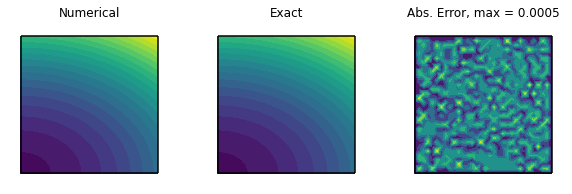

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 6))


axes[0].tricontourf(mesh._triang, solution[:, 0], levels=20)
axes[1].tricontourf(mesh._triang, ud(mesh.nodes)[:, 0], levels=20)
axes[2].tricontourf(mesh._triang, np.abs(solution[:, 0] - solution_exact[:, 0]))

titles = ['Numerical' % err, 'Exact', 'Abs. Error, max = %.4f' % err]

for i, ax in enumerate(axes):
    ax.add_collection(
        LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
    ax.set_aspect('equal'); ax.axis('off')
    for method in [ax.set_xlim, ax.set_ylim]:
        method((-0.1, 1.1))
    ax.set_title(titles[i])


plt.show()